# Project Name: Sentiment Analysis of USA Ailrlines Tweets
The following code will compute the sentiment of text information for tweets posted in 2015 regarding US airlines. it will cover the below sections: 
1. Data Clenaing
2. Exploratory Visualization Analysis
3. Model Preparation
4. Model Implementation
5. Results & Discussion

## Background and Problem Defination

**Sentiment Analysis** is a branch of Natural Language Processing (NLP) that allows us to determine algorithmically whether a statement or document is “positive” or “negative”.

Sentiment analysis is a technology of increasing importance in the modern society as it allows individuals and organizations to detect trends in public opinion by analyzing social media content. As the airline industry become increasingly competitive, airline companies are always trying their best to satisfy customer experience. Through sentiment analysis, these companies can obtain information on customers’ overall satisfaction and adopt business strategies to address aspects with low satisfaction.

The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted in 2015 regarding US airlines - and answer the research question: **“What can public opinion on Twitter tell us about the US airlines in 2015?”** The goal is to essentially use sentiment analysis on Twitter data to get insight into the people’s opinions on US airlines.


## Datasets

Two sets of data are used for this assignment. The generic_tweets.txt file contains tweets that have had their sentiments already analyzed and recorded as binary values 0 (negative) and 4 (positive). Each line is a single tweet, which may contain multiple sentences despite their brevity. The comma-separated fields of each line are:


**class:** the polarity of each tweet (0 = negative emotion, 4 = positive emotion)

**id:** the id of the tweet (e.g. 2087)

**date:** the date of the tweet (e.g. Sat May 16 23:58:44 UTC 2009)

**query:** the query (e.g. lyx). If there is no query, then this value is NO_QUERY.

**user:** the user that tweeted (e.g. robotickilldozr)

**text:** the text of the tweet (e.g. Lyx is cool)


The second data set, US_airline_tweets.txt, contains a list of tweets regarding several US airlines. The comma-separated fields of each line are:

**id:** the id of the tweet

**sentiment:** can be “positive” or “negative”

**negative_reason:** reason for negative tweets. Left blank for positive tweets.

**user:** the user that tweeted

**retweet_count:** number of retweets

**text:** the text of the tweet

Both datasets have been collected directly from the web, so they may contain html tags, hashtags, and user tags.

In [1]:
#!pip install nltk
#!pip install numpy
#!pip install pandas
#!pip install sklearn
# !pip install WordCloud
# !pip install matplotlib==3.1.0

In [2]:
#Importing necessary and used libraries along with machine learning modules
import pandas as pd
import numpy as np
import string 
import html
import re
import matplotlib
import matplotlib.pyplot as plt 
import os
from nltk.tokenize import word_tokenize
import nltk
import seaborn as sns
from wordcloud import WordCloud

# sklearn libraries for model implementation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
%matplotlib inline


from matplotlib.pyplot import figure

import sys
import warnings
warnings.filterwarnings("ignore")

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Matplotl: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.1
Numpy: 1.18.1
Matplotl: 3.1.3
Seaborn: 0.10.0


# 1. Data Cleaning 
In this section a full integerated function named "parsed_data" was coded to do the following tasks:

1. Removing all html tags and attributes 
2. Replacing all html character codes with an ASCII equivalent
3. Removing all urls 
4. Removing extra white spaces
5. Removing punctuation marks and keeping only letters
6. Converting letters into lowercase
7. Removing Stop Words by using given list of stop words in assignment 

Why removing stopwords? stopwords are words that have very little significance in determining associate sentiment. Removing them will reduce noisy in data, however, it is not good practive to remove them while working with LSTM model. LSTM model has the capability of learning semanatic meaning of words, thus removing them might affect model performance for LSTM. 

8. Add @ to each text column as it will be used located airlinename
9. Tokenizing the tweet, and if an empty tweet after processing it will be preserved 


In [3]:
# Definging a function to remove html tags
def remove_html_tags(text):
    clean = re.compile(r'/<[^>]+>/')
    return re.sub(clean, '',text)

hasht= set(string.punctuation)
# Defining a function to remove punctuation marks exclding '@'.  
def remove_punc(text):
    return "".join(list((map(lambda x:" " if x  in hasht else x, text ))))

# Defining a function to remove the stop words from tweets,all stop words were imported from given txt file of stop words. 
def remove_stopwords(twts):
    stop_words = open('stop_words.txt', 'r').read().split()      
    
    twts = twts.split()                     
    
    nonstop = " ".join(w for w in twts if not w in stop_words)     
    
    return nonstop

In [4]:
def parsed_data(text):
    
    # Removing URLs
    m = re.sub(r"http\S+", "", text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', m)
    
    # Removing html tags
    text = remove_html_tags(text)
    
    # Replacing html character with an ASCII equivalent
    text = html.unescape(text)
    
    # Removing extra white spaces
    text = re.sub('[\s]+', " ", text)
    
    # Removing Punctuation marks
    text = remove_punc(text) 
    
    # Keep only letters
    text = re.sub("[^a-zA-Z]+", " ", text)
    # Converting to lowercase
    text = text.lower()

    
    # Removing stopwords
    text = remove_stopwords(text)
    #adding @ for purpose of locating airlines
    text = "@" + text 
    # Tokenize the tweet
    tokens = text.split()

    return (" ".join(tokens)).strip()


## 1.1 Cleaning Generic Tweets 
1. Generic tweet file will be imported and read file as data frame file by using pd library
2. To avoid complexity in removing noise and cleaning, some columns are not necessary here, so they will be dropped "ID, Query and User"
3. Replacing and Mapping "Class" column with "Sentiment" column that cotains values of 0 as negative and 4 as positive, however, we will conver them into 0 as negative and 1 as positive. 
4. Converting the timestamp into Date for the purpose of visulizing the data later on
5. The data frame of generic tweets will be cleaned by using the funtion "parsed_data"

In [5]:
# Read the data 
dtf=pd.read_csv('generic_tweets.txt')
dtf.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dtf.shape

(200000, 6)

In [7]:
# Dropping unnecessary columns from generic tweets data frame 
dtf= dtf.drop(['id','query','user'], axis=1)
#dtf

# Replacing and Mapping of Class column to sentiments column
dtf['sentiment'] = dtf['class'].apply(lambda x: 1 if x > 0 else 0)
dtf= dtf.drop(['class'], axis=1)
dtf['test']= 0

#Conversion of time to Date
dtf['date'] = pd.to_datetime(dtf['date'])
dtf['date'] =dtf['date'].apply(lambda x: x.date() )
dtf['date'] = dtf.date.sort_values()
dtf.head()

,date,text,sentiment,test
0,2009-04-06,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,0
1,2009-04-06,is upset that he can't update his Facebook by ...,0,0
2,2009-04-06,@Kenichan I dived many times for the ball. Man...,0,0
3,2009-04-06,my whole body feels itchy and like its on fire,0,0
4,2009-04-06,"@nationwideclass no, it's not behaving at all....",0,0


In [8]:
# Cleaning loop and store cleaned results in list clean_dtf
clean_dtf = dtf['text'].apply(lambda text:parsed_data(text))

# Converting clean list into data frame file and append all necessary files from uncleaned data frame
clean_dtf = pd.DataFrame(clean_dtf,columns = ['text'])
clean_dtf ['sentiment'] = dtf['sentiment']
clean_dtf ['date'] = dtf['date']
clean_dtf ['test'] = dtf['test']
clean_dtf.head()

,text,sentiment,date,test
0,@switchfoot awww bummer shoulda david carr thi...,0,2009-04-06,0
1,@upset update facebook texting cry result scho...,0,2009-04-06,0
2,@kenichan dived times ball managed save rest b...,0,2009-04-06,0
3,@body feels itchy fire,0,2009-04-06,0
4,@nationwideclass behaving mad,0,2009-04-06,0


In [9]:
# Arrange columns for reading simplicity
clean_dtf=pd.DataFrame(clean_dtf,columns=['sentiment','date','test','text'])
clean_dtf.head()

,sentiment,date,test,text
0,0,2009-04-06,0,@switchfoot awww bummer shoulda david carr thi...
1,0,2009-04-06,0,@upset update facebook texting cry result scho...
2,0,2009-04-06,0,@kenichan dived times ball managed save rest b...
3,0,2009-04-06,0,@body feels itchy fire
4,0,2009-04-06,0,@nationwideclass behaving mad


## 1.2 Cleaning USA Airlines Data
1. US airlines file will be imported and read file as data frame file by using pd library
2. To avoid complexity in removing noise and cleaning, only the "ID" column will be dropped as it does not required for data analysis
3. Replacing "Sentiment" column of postive and negative into integers where 0 for "negative" and 1 for "positive" 
4. As "negative_reason column contains NaN, we have to remove it and replace it with empty space (nonvalue). 
5. The data frame of US airlines will be cleaned by using the funtion "parsed_data"

In [10]:
# Reading the US airlines file
USA_dtf=pd.read_csv('US_airline_tweets.csv')
USA_dtf.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


In [11]:
USA_dtf.shape

(11541, 6)

In [12]:
# Dropping unnecessary columns from US airlines data frame 
USA_dtf= USA_dtf.drop(['id'], axis=1)

# Converting sentiments into integers of 0 and 1
USA_dtf['sentiment'] = USA_dtf['sentiment'].apply(lambda x: 1 if x =='positive' else 0)
USA_dtf['test']= 0

# Replacing  NaN values with ''
USA_dtf = USA_dtf.fillna(' ')
USA_dtf.head()

,sentiment,negative_reason,user,retweet_count,text,test
0,1,,jnardino,0,@VirginAmerica plus you've added commercials t...,0
1,0,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,0
2,0,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,0
3,0,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,0
4,1,,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",0


In [13]:
# Cleaning loop and store cleaned results in list clean_USA_dtf
USA_dtf1 = USA_dtf.text[:]
clean_USA_dtf =[]
for t in USA_dtf1:
    clean_USA_dtf.append(parsed_data(t))
# clean_USA_dtf

In [14]:
# Converting clean list into data frame file and append all necessary files from uncleaned data frame
clean_USA_dtf = pd.DataFrame(clean_USA_dtf,columns = ['text'])
clean_USA_dtf ['sentiment'] = USA_dtf['sentiment']
clean_USA_dtf ['negative_reason'] = USA_dtf['negative_reason']
clean_USA_dtf ['test'] = USA_dtf['test']
clean_USA_dtf ['user'] = USA_dtf['user']
clean_USA_dtf ['retweet_count'] = USA_dtf['retweet_count']
clean_USA_dtf.head()

,text,sentiment,negative_reason,test,user,retweet_count
0,@virginamerica ve commercials experience tacky,1,,0,jnardino,0
1,@virginamerica aggressive blast obnoxious ente...,0,Bad Flight,0,jnardino,0
2,@virginamerica big bad thing,0,Can't Tell,0,jnardino,0
3,@virginamerica seriously pay flight seats didn...,0,Can't Tell,0,jnardino,0
4,@virginamerica time fly vx ear worm won,1,,0,cjmcginnis,0


In [15]:
# Arrange Columns for reading simplicity
clean_USA_dtf=pd.DataFrame(clean_USA_dtf,columns=['user','sentiment','test','retweet_count','negative_reason','text'])
clean_USA_dtf.head()

,user,sentiment,test,retweet_count,negative_reason,text
0,jnardino,1,0,0,,@virginamerica ve commercials experience tacky
1,jnardino,0,0,0,Bad Flight,@virginamerica aggressive blast obnoxious ente...
2,jnardino,0,0,0,Can't Tell,@virginamerica big bad thing
3,jnardino,0,0,0,Can't Tell,@virginamerica seriously pay flight seats didn...
4,cjmcginnis,1,0,0,,@virginamerica time fly vx ear worm won


#### Capture airline name from tweets, steps:

1. Capture the tweet that belongs to each airline by usnig "@" hashtages, where "@" was excluded from punctuation in cleaning data function for this purpose. 
2. As data contains some short forms of airline name, a hashtag dictinary was created to match each form with it long form (a key and its value). Notices all the airlines dictonary key and values were obtained from internet.
3. After capturing the tweet, a new column called "twitter_hashtags" was created to sort (appending) each tweet along its correspnding airlines.  
4. There is possibiity that tweet is written by the airline compnay itself, so we havr to invistigate that and append it to our tweets bag of word list. To do that, it is typical for most of companies to use company name, for example,usairways.  

In [16]:
# Defining a function that will find all tweets that contains @ and append it to new column named twitter_hashtag
hash_re = re.compile(r'(?:@[\w_]+)')
def find_hash(text):
    return hash_re.findall(text)

clean_USA_dtf['twitter_hashtag']= clean_USA_dtf['text'].apply(lambda x: [x.lower() for x in find_hash(x)])


# Hashtage dictionary created that contains @shortform of airlines name as key and full airline name as value
hashtag_dict = {'@deltaassist':'Delta Assist','@wheelsup':'Wheels Up', '@hawaiianfares':'Hawaiian Airlines', '@porterairlines':'Porter Airlines',
               '@southwestair':'SouthWest Airlines','@virginamerica':'Virgin America','@qantasusa':'Qantas Airways USA','@delta':'Delta',
                '@usairways':'US Airways','@jetblue':'JetBlue Airways','@united':'United Airlines','@flyfrontier':'Frontier Airlines',
                '@alaskaair':'Alaska Airlines','@americanair':'American Airlines','@hawaiianair':'Hawaiian Airlines','@unitedairlines':'United Airlines',
                '@airfranceus':'Air France US', '@cathaypacificus':'Cathay Pacific US', '@flysaa_us':'SouthAfricanAirways','@hainanairlines':'Hainan Airlines'}
# Creating a tweets bag of words
twt_bag_list= []

# A loop was created to search in new added column "twitter_hashtag" for shortform of airlines name and split it and then compare it to hashtag dictionary
for z in clean_USA_dtf['twitter_hashtag']: #searching column
    for y in z:
        y = y.rstrip(string.digits) # splitting words by removing all words other than spcified as sting such that it is clean and ready to be compared in the next line
        if y in hashtag_dict.keys(): # Comparing and checking if airline is in hashtag dictionary
            #print(str(y))
            twt_bag_list.append(hashtag_dict[y]) # Adding word into bag of list
        else: 
            twt_bag_list.append('Unknown')
        

# A loop was creaated to check if the tweet made by airline itself, and to do so we search inside user column
count=-1
for z in twt_bag_list:
    count= count+1
    if z == "Unknown":
        check_user = "@"+ str(clean_USA_dtf['user'][count]) # adding @ to user name to match created dictionary keys of airlines names
        check_user = check_user.lower() #converting user name into lowercase as dictionary keys are in lowercase 
        if check_user in hashtag_dict.keys():# checking if user name is in dictinary, it will appended it to bag of list
            twt_bag_list[count] = hashtag_dict[check_user]

column_values = pd.Series(twt_bag_list) #creating a one dimensional series for tweets bag list from dictinary
# Rearrange above process and put all new analysized twt_bag_ into new column names "twitter_hashtags"
clean_USA_dtf.insert(loc=0, column='twitter_hashtags', value=column_values)
# Remove Unknown tweets as it belongs to a user. Though we have checked if that unknown belongs to airline by checking use column
clean_USA_dtf = clean_USA_dtf[~clean_USA_dtf['twitter_hashtags'].str.contains("Unknown")]
# Drop dummy varible for hashtage, not need now!
clean_USA_dtf= clean_USA_dtf.drop(['twitter_hashtag'], axis=1)

#Check unique values, as we onyl expect airlines nothing else!
print('Unique US airlines',clean_USA_dtf['twitter_hashtags'].unique())
print('Shape of US airlines data is',clean_USA_dtf.shape)

Unique US airlines ['Virgin America' 'United Airlines' 'SouthWest Airlines' 'JetBlue Airways'
 'US Airways' 'American Airlines' 'Delta Assist']
Shape of US airlines data is (11409, 7)


# 2. Exploratory Visualization Analysis 
It is always good practice to visualize your data as it can give you some guidlines about your dependant and independant parameters and how they are distribuated. Therefore, we can have a clear image on how to carry on the next step whcih is building machine learning alogarithm. And again visulaization analysis will be splitted into two parts: 
1. Visualization of generic tweets. 
2. visualization of US airlines tweets. 

## 2.1 Visualization of Generic Tweets
As we examined the generic tweets in cleaning part, we realized that this data can be visualized based on the following appoach:
1. Total number of positive and negatives tweets. This visualization will give a clear picture probability distibuation in this data. 
2. It will be visualized based on dates such that dates can be an indicator for high peak period for traveling or any customer operational expenses. 

### 2.1.1 Visualization of Total Positive & Negative Tweets
From below plot and results, we can see that we have equal number of positive and negative tweets that is equal probability of 50% each. That is we have balance data good to train the model with. 

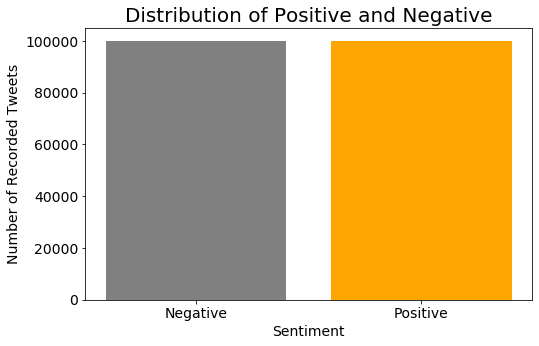

In [17]:
# From microsoft excel pivot concept, I figure it out that it will be easier to develop a pivot table for specificed data to plot, such that old files are not mixed with new ones
piv_tab1 = pd.pivot_table(clean_dtf,values='test' , index=['date', 'sentiment'],aggfunc="count")
piv_tab2 = pd.pivot_table(clean_dtf,values='test' , index=['sentiment'],aggfunc="count")

dtf1 = pd.DataFrame(piv_tab1.to_records())
# print(dtf1)

dtf2 = pd.DataFrame(piv_tab2.to_records())
# To depict the destribuation of probaility, a bar plot was used
fig = plt.figure(figsize=(8,5))

my_bag=['Negative', 'Positive']
plt.bar(dtf2.sentiment, dtf2.test,color=["gray","orange"])
plt.xticks(dtf2.sentiment, my_bag)
plt.xlabel('Sentiment',fontsize=14)
plt.ylabel('Number of Recorded Tweets',fontsize=14)
plt.title('Distribution of Positive and Negative',fontsize=20)
plt.tick_params(labelsize=14)
plt.show()
fig.savefig('Generic Tweets Class Distributions.png');
# clean_dtf.sentiment.value_counts()

# print(dtf2)

### 2.1.2 Visualization of Positive & Negative Tweets Based on Date
The below plot demonstrate the how sentiments varied based on the date, as it can be seen that data was only collected for two months April and May of 2009. It can also be seen that positive sentiments in May almost not existed, this could help in understand how the alogarith can be develop in case this data will be used for training purpose. 

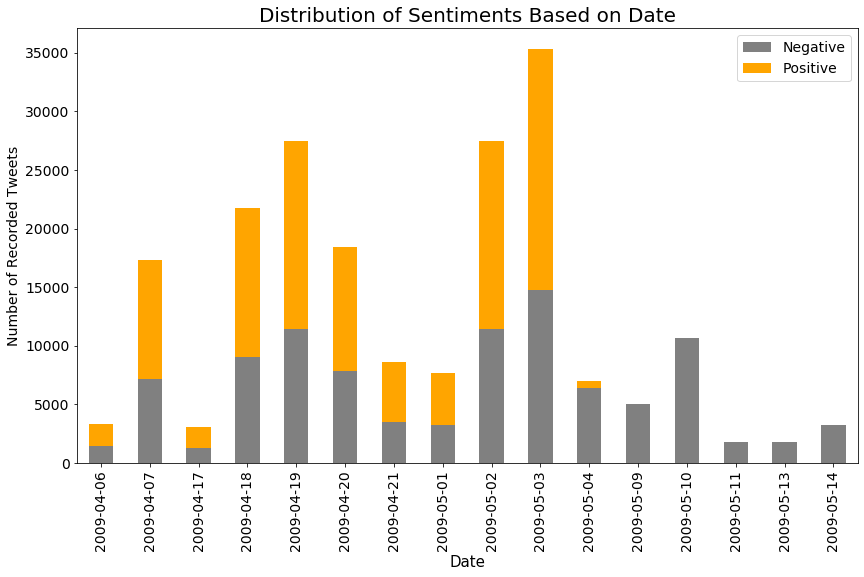

In [18]:
# As stated above in first visualization, using pivot table can help a lot in plotting
table_dtf = dtf1.pivot(index='date', columns='sentiment', values='test')
table_dtf= table_dtf.fillna(0) # To check no NaN value present in table to avoid error in data 
 
table_dtf.loc[:,[0,1]].plot.bar(stacked=True, color=["gray","orange"], figsize=(14,8))
plt.title('Distribution of Sentiments Based on Date',fontsize=20)
plt.ylabel('Number of Recorded Tweets',fontsize=14)
plt.xlabel('Date',fontsize=15)
plt.legend(['Negative', 'Positive'],fontsize=14)
plt.tick_params(labelsize=14);

## 2.2 US Airlines Visulaization 
As US airlines contain many varibles that can help in visualizing the data, the following approach will be used:
1. Like generic tweets, we will visualize data based on total number of positive and negative tweets such that we can know the distribution probability and skewness of the data. 
2. Data will be visualized based on airlines tweets (as assignment required).

### 2.2.1 Visualization of Total Number of Postive and Negative Tweets
In the first trial of plotting the data, we only plot total number of positive and negative tweets in US airlines, however, as it can be see that negative sentiments overcome postive sentiments, so there is no equal probability. Data is skewed into negative sentiments. Therefore, it would be a good idea to examine negative sentiments based on the negative reason and count number of occurs. From the negative reason plot bar, we can see that most of negative reason in all airlines are associated with customer service issue and late fligh. Therfore, these compnaies have to reevalute their customer service and fligh time. The following plots shows: 
1. Plot of Total number of positive and negative tweets. 
2. Plot of negative tweets based on negative reason. 

   sentiment  test
0          0  9096
1          1  2313


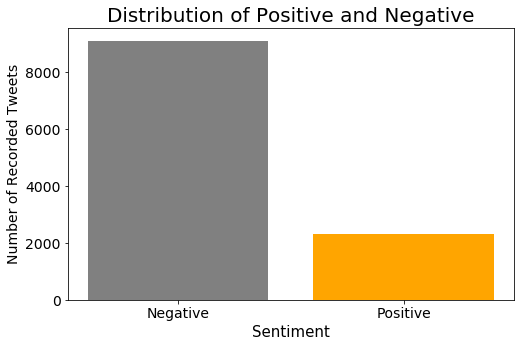

In [19]:
# The Data pivot_table to plot positive and negative sentiments 
piv_tab3 = pd.pivot_table(clean_USA_dtf,values='test' , index=['sentiment'],aggfunc="count")
dtf3 = pd.DataFrame(piv_tab3.to_records())
print(dtf3)
# Plot bar for total sentiments
fig = plt.figure(figsize=(8,5))

my_bag=['Negative', 'Positive']
plt.bar(dtf3.sentiment, dtf3.test,color=["gray","orange"])
plt.xticks(dtf3.sentiment, my_bag)
plt.xlabel('Sentiment',fontsize=15)
plt.ylabel('Number of Recorded Tweets',fontsize=14)
plt.title('Distribution of Positive and Negative',fontsize=20)
plt.tick_params(labelsize=14)
plt.show();

               negative_reason  test
0                   Bad Flight   577
1                   Can't Tell  1162
2             Cancelled Flight   841
3       Customer Service Issue  2887
4              Damaged Luggage    74
5  Flight Attendant Complaints   478
6      Flight Booking Problems   525
7                  Late Flight  1653
8                 Lost Luggage   722
9                    longlines   177


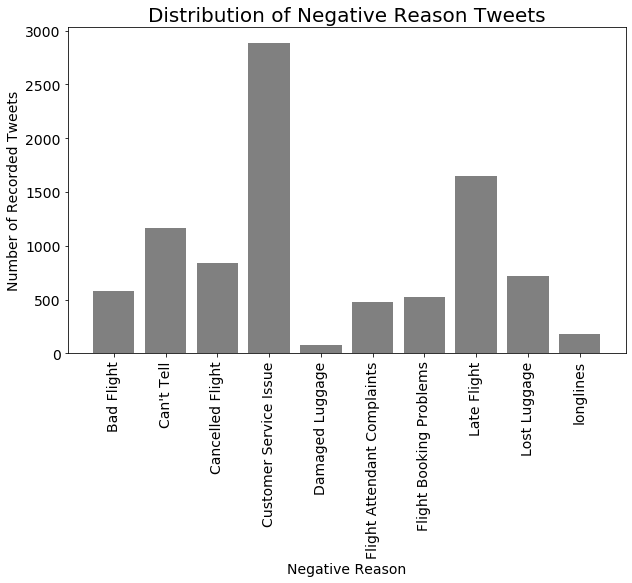

In [20]:
piv_tab4 = pd.pivot_table(clean_USA_dtf.loc[clean_USA_dtf['sentiment']== 0] ,values='test' , index=['negative_reason',],aggfunc="count")
dtf4 = pd.DataFrame(piv_tab4.to_records())
print(dtf4)

# Plot bar for negative reason sentiments
fig = plt.figure(figsize=(10,6))
plt.bar(dtf4.negative_reason, dtf4.test,color="gray")
plt.xlabel('Negative Reason',fontsize=14)
plt.ylabel('Number of Recorded Tweets',fontsize=14)
plt.xticks(rotation=90) # To rotate words vertically
plt.title("Distribution of Negative Reason Tweets",fontsize=20)
plt.tick_params(labelsize=14)
plt.show();

I would like to understand further the negative distrbution among each airline. Thus the next plot will show neative reaason for every airline. 

In [21]:
# Delta airline has only 2 negative reasons, thus I did not include them in plots.
airlines = ['Virgin America','United Airlines','SouthWest Airlines','JetBlue Airways','US Airways','American Airlines']
def NR_Count(Airline):
    
    a=clean_USA_dtf[clean_USA_dtf['twitter_hashtags']==Airline]
    count=dict(a['negative_reason'].value_counts())
    Unique_reason=list(clean_USA_dtf['negative_reason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != ' ']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline):
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(a['Reasons'],count, color=['gray','orange','royalblue','sienna','darkgreen','pink','brown','coral','teal','tan'])
    plt.xticks(a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

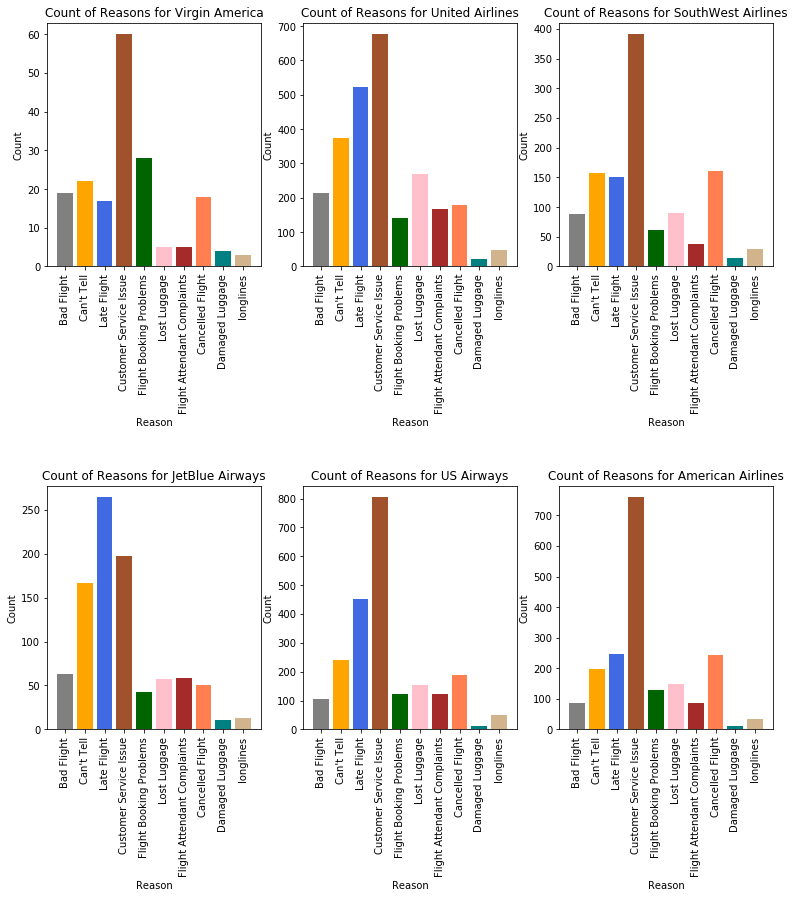

In [22]:
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)
    plt.savefig('Airlines Negative Tweets.png')
#     plt.show();

The above six plots indincate some dominant neagtive reasons, can be summarized in short: 

1. The common complains about **Virgin America Airline** are *customer service issues* followed by *flight booking problems*. 
2. **United Airlines** has complains related to *customer service issues* and *late flights*. 
3. The common complains about **SouthWest Airlines** are *customer service issues*, *late flight* and *cancelled flights*.
4. The common complains about **jetBlue Airways** are *late flights* and *customer service issues*.
5. The common complains about **US Airways** are *customer service issues* and *late flights*
6. The common complains about **American Airlines** are *customer service*, *cancelled flights* and *late flights*. 

### 2.2.2 Visualization Based on US Airline Tweets
To carry on visualization based on US airlines tweets, the following steps were proformed. 
1. Visualizing all positive words for US airlines as word cloud. 
2. Visualizing all negative words for US airlines as word cloud.
3. Visualizing distrbution of tweets per airlin. 
Analysing the plots: 
1. From the US positve word cloud, we can see that the word "Southwest air", "jetblue" have the highest frequency for positive tweets, along with it we can see words like "best", "amazing", "good customer service", "great", "love", "nice", and "happy" etc. 
2. From the US negative word cloud, we can see that the word "americanairlines", "unitedairline","usaairways" are the biggest words appeared which indicates more negative responsed associated with that airline tweets.However,"virginamerica" has the smallet word appeared relative to other airlines words, this indicates that public can expect vigine airlines as a good airline compared to others. Along with that, we can also see some negative words such as "cancelled flight", "delayed","help","canceled flight","booking problems", "late flight" and etc. 
3. United Airlines has the highest number of negative tweets, US Airways and American Airlines takes second and third place in term of number of negative tweets. 
4. The other airlines Virgin America, SouthWest and JetBlue are having a low negative tweets, this could indicate that they provide a good services compared to United Airlines, US Airways and American Airlines, however, it is still needed to be improved. 
5. Regarding Delta Assist, as shown below, it has only two negative tweets and zero positive tweets. I would say that data given to us lack information about Delta Assist airline, therefore, no concusion can be made, I might take it out from Modeling preparation step. 

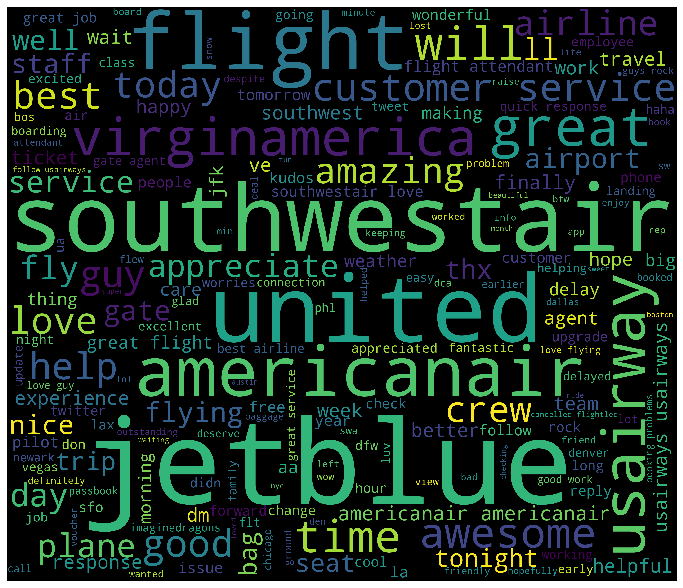

In [23]:
# World Cloud Visualaization for positive tweets of US airlines. 
USA_positive = clean_USA_dtf[clean_USA_dtf['sentiment']==1]
USA_positive_text = USA_positive['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))

USA_positive_words= pd.Series(USA_positive_text).str.cat(sep=' ')

positive_wordcloud = WordCloud( background_color='black',
                      width=3500,
                      height=3000
                     ).generate(USA_positive_words)

# Plotting word cloud
plt.figure(1,figsize=(12, 12))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.savefig('Positive Word Cloud.png')
plt.show();

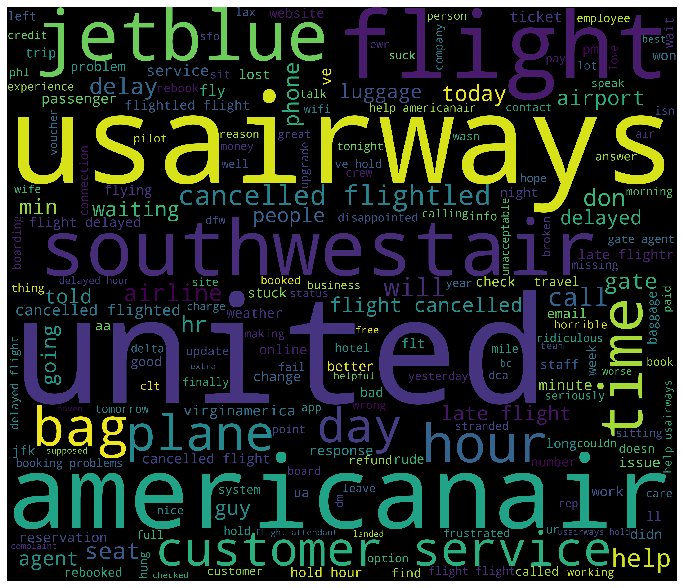

In [24]:
# World Cloud Visualaization for positive tweets of US airlines. 
USA_negative = clean_USA_dtf[clean_USA_dtf['sentiment']==0]
USA_negative_text = USA_negative['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))

USA_negative_words= pd.Series(USA_negative_text).str.cat(sep=' ')

negative_wordcloud = WordCloud( background_color='black',
                      width=3500,
                      height=3000
                     ).generate(USA_negative_words)

# Plotting word cloud
plt.figure(1,figsize=(12, 12))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.savefig('Negative Word Cloud.png')
plt.show();

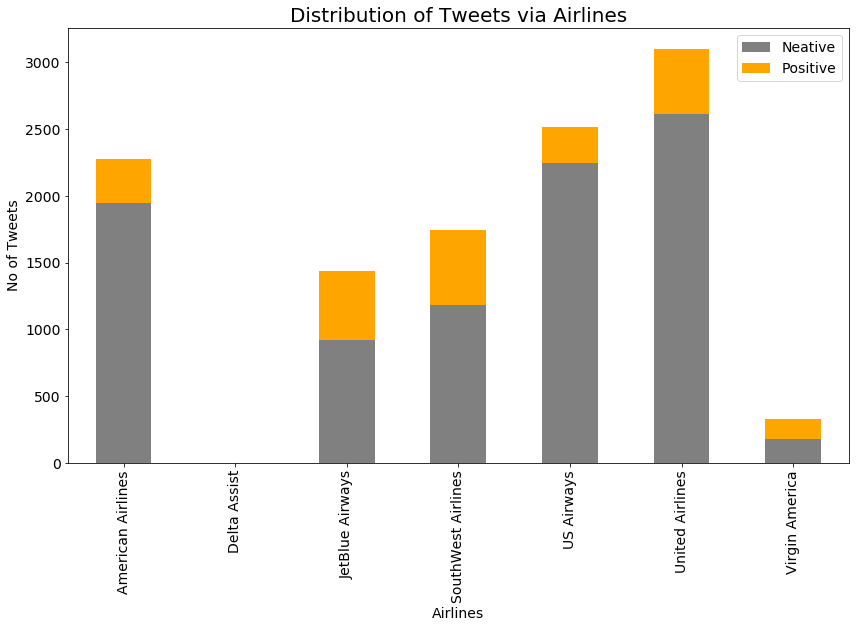

In [25]:
#Visualizing Airlines based on tweets
tab5 = pd.pivot_table(clean_USA_dtf, values='test', index=['twitter_hashtags','sentiment'],aggfunc="count")
dtf5= pd.DataFrame(tab5.to_records())

piv_tab5 = dtf5.pivot(index='twitter_hashtags', columns='sentiment', values='test')
piv_tab5= piv_tab5.fillna(0)
# piv_tab5

# fig = plt.figure()
piv_tab5.loc[:,[0,1]].plot.bar(stacked=True, color=["gray","orange"],figsize=(14,8))
plt.xlabel("Airlines",fontsize=14)
plt.ylabel("No of Tweets",fontsize=14)
plt.legend(["Neative", "Positive"],fontsize=14)
plt.title("Distribution of Tweets via Airlines",fontsize=20)
plt.tick_params(labelsize=14)
plt.show();


The fraction of negative tweets for an airline / total number of tweets for an airline is not uniform. Delta Assist has only 2 reasons abd both are negative ones, thus, it is a fraction of 100%. On the other hand, we can see that **Virgin America** has about 50% negative tweets from total tweets, outperforming other airlines. 

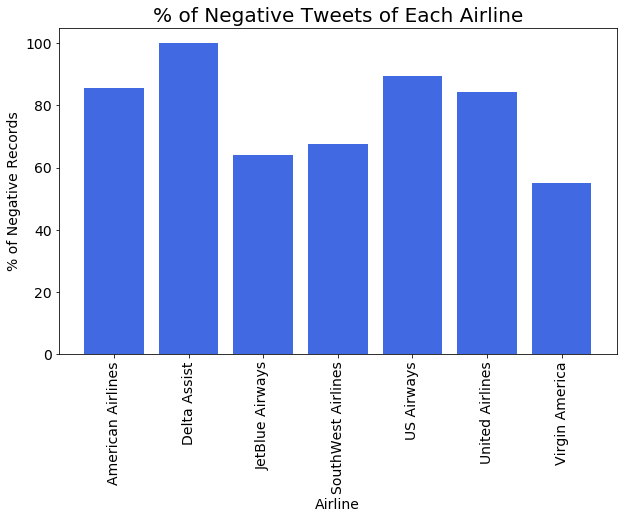

In [26]:
# We want to know percentage of negative records out of total for every airline
dtf5_a = dtf5[dtf5['sentiment']==0]
tab5_a = pd.pivot_table(dtf5,values='test',index=['twitter_hashtags'],aggfunc=sum)
dtf5_b = pd.DataFrame(tab5_a.to_records())
dtf5_c = pd.merge(dtf5_a, dtf5_b, on='twitter_hashtags')
dtf5_c['percentage'] = np.round(100 * dtf5_c['test_x'] / dtf5_c['test_y'],2)

fig = plt.figure(figsize=(10,6))
plt.bar(dtf5_c['twitter_hashtags'], dtf5_c['percentage'],color='royalblue')
plt.xlabel('Airline',fontsize=14)
plt.ylabel('% of Negative Records',fontsize=14)
plt.xticks(rotation=90)
plt.title("% of Negative Tweets of Each Airline", fontsize=20)
plt.tick_params(labelsize=14)
plt.show();

# 3. Model Preparation
In this part, based on cleaned date obtained from generic tweet, we will prepare a model by using Countern Vectorizer to give count of the words and frequence and give weightage to the words from frequency.Then conver the text (words) document into a matrix of token counts. To elaborate more,the following steps will be run: 
1. Extracting tweet text, and removing @ from tweet text, to avoid error during preparing model,why? because I intentially added @ to tweet text to use it to develope a hashtage column contains the airline name for plot and visualization in US airline visulaization setion above. 
2. Tokenize the words count by using Count Vectorizer and obtain the weight.
3. Fit data and convert it into a matrix of token count. 
4. Splitting data into features (tweets matrix as X) and training data (sentitments as y), where 70% of sentiment will be used for training, and 30% will be used for testing. 
5. An accuracy function will be defined to perform comparsion between alogarithm, calculate precision, recall, f1-score by using classification report function. 
Accuracy: How many true predictions did the model make.
    $$accuracy = \frac{correct\ predictions}{samples}$$
 Recall: For one class, how many of the class samples did the model find in the testing set and correctly identify:
    $$Recall = \frac{TP}{TP + FN}$$
Precision :For one class, of all the samples predicted as that class, how many were correct predictions:
    $$Precision = \frac{TP}{TP + FP}$$
6. Naive Bayes Classifer will be used here as it is a method to predict the liklihood that an event will occur give training data. From Naive Bayes, we will use Bernoulli "BNB"as it is good for making predictions from binary feautre since we have a matix that contains 0 and 1. 
7. Confusion matrix for model is calculated. 
8. Finally logistic regression score will predicted
9. We can compare the results from prediction of Bernoulli abd Logistic regression,based on high score, we will run the model to predict US sentiment in section 4 below.

**Source**:
1. Count Victorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html?fbclid=IwAR1uz3a5CINz0pKd-Xd6yU8jASbSJ0GcGSE8Cf0eg_nnpGRHzn2dsOlBhxk

## 3.1 Prepare Model from Generic Tweets

In [27]:
# Exctracting only the text from clean generic tweets 
generic_tweets = clean_dtf['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))


# Using Count Vectorization to tokenize the words and then develope matric of token counts
vectorizer = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
vectorizer.fit(generic_tweets)
txt_fitted_generic_CV = vectorizer.fit_transform(generic_tweets)


# Splitting features data into training and testing 
X = txt_fitted_generic_CV
y = clean_dtf['sentiment'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)


#finding the disctinct categories for sentiment in generic tweets
category_id_df = clean_dtf['sentiment'].drop_duplicates()
category_to_id = list(category_id_df.values)

In [28]:
# Defining a function for the performance comparison of different algorithms

def algorithm_accuracy(model,X_train, X_test, y_train, y_test):
    
    if model == 'BernoulliNB':
        BER_name,BNB=(('BNB', BernoulliNB()))
    
        BER_model=BNB.fit(X_train,y_train)#fitting by using Bernoulli 
        by_predict = BER_model.predict(X_test)#preducting by using test 
        BER_score = accuracy_score(y_test,by_predict)# evaluate the accuracy due to using Bernoulli
        print(BER_name)
        print(BER_score) 
        print(classification_report(y_test,by_predict))
        print('------------------------------------------')
        cm = confusion_matrix(by_predict, y_test) # Finding the confusing matrix for the first model for Bernoulli+Plot
        fig,ax = plt.subplots(figsize=(5,5))
        sns.heatmap(cm,annot=True,fmt='d',annot_kws={"size":14,},xticklabels=category_to_id, yticklabels=category_to_id)
        plt.ylabel('Actual',fontsize=14)
        plt.xlabel('Predicted',fontsize=14)
        plt.show();
  
    #Logistic Regreesion model
    if model == 'LogisticRegression':
        R_name,logR=(('LogR', LogisticRegression()))
        R_model = logR.fit(X_train,y_train) # Training the model
        y_predict = R_model.predict(X_test) # Predicting the test data
        R_score = accuracy_score(y_test,y_predict) #Evaluating the accuracy of the model 
        print(R_name)
        print(R_score)
        print(classification_report(y_test,y_predict))
        print('------------------------------------------')
        cm = confusion_matrix(y_predict, y_test) # Finding the confusing matrix for the first model Logistic Regression+Plot
        fig, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(cm,annot=True,fmt='d',annot_kws={"size":14,},xticklabels=category_to_id, yticklabels=category_to_id)
        plt.ylabel('Actual',fontsize=14)
        plt.xlabel('Predicted',fontsize=14)
        plt.show();
    
    
#     # Random Forest model
#     if model == 'RandomForestClassifier':
#         RF_name,rfc=(('Rfc', RandomForestClassifier(n_estimators=200)))
#         Rfc_model = rfc.fit(X_train,y_train) # Training the model
#         y_predict = Rfc_model.predict(X_test) # Predicting the test data
#         R_score = accuracy_score(y_test,y_predict) #Evaluating the accuracy of the model 
#         print(RF_name)
#         print(R_score)
#         print(classification_report(y_test,y_predict))
#         print('------------------------------------------')
#         cm = confusion_matrix(y_predict, y_test) # Finding the confusing matrix for the first model Logistic Regression+Plot
#         fig, ax = plt.subplots(figsize=(10,10))
#         sns.heatmap(cm,annot=True,fmt='d',annot_kws={"size":14,},xticklabels=category_to_id, yticklabels=category_to_id)
#         plt.ylabel('Actual',fontsize=14)
#         plt.xlabel('Predicted',fontsize=14)
#         plt.show();
    
#     # GradientBoosting model
#     if model == 'GradientBoostingClassifier':
#         GB_name,gbc=(('GB', GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42)))
#         GBc_model = gbc.fit(X_train,y_train) # Training the model
#         y_predict = GBc_model.predict(X_test) # Predicting the test data
#         R_score = accuracy_score(y_test,y_predict) #Evaluating the accuracy of the model 
#         print(GB_name)
#         print(R_score)
#         print(classification_report(y_test,y_predict))
#         print('------------------------------------------')
#         cm = confusion_matrix(y_predict, y_test) # Finding the confusing matrix for the first model Logistic Regression+Plot
#         fig, ax = plt.subplots(figsize=(10,10))
#         sns.heatmap(cm,annot=True,fmt='d',annot_kws={"size":14,},xticklabels=category_to_id, yticklabels=category_to_id)
#         plt.ylabel('Actual',fontsize=14)
#         plt.xlabel('Predicted',fontsize=14)
#         plt.show();
    
#     # AdaBoostClassifier model
#     if model == 'AdaBoostClassifier':
#         AB_name,abc=(('AB', AdaBoostClassifier()))
#         ABc_model = abc.fit(X_train,y_train) # Training the model
#         y_predict = ABc_model.predict(X_test) # Predicting the test data
#         R_score = accuracy_score(y_test,y_predict) #Evaluating the accuracy of the model 
#         print(AB_name)
#         print(R_score)
#         print(classification_report(y_test,y_predict))
#         print('------------------------------------------')
#         cm = confusion_matrix(y_predict, y_test) # Finding the confusing matrix for the first model Logistic Regression+Plot
#         fig, ax = plt.subplots(figsize=(10,10))
#         sns.heatmap(cm,annot=True,fmt='d',annot_kws={"size":14,},xticklabels=category_to_id, yticklabels=category_to_id)
#         plt.ylabel('Actual',fontsize=14)
#         plt.xlabel('Predicted',fontsize=14)
#         plt.show();
    
#     return R_score

BNB
0.73335
              precision    recall  f1-score   support

           0       0.72      0.77      0.74     29851
           1       0.75      0.70      0.72     30149

    accuracy                           0.73     60000
   macro avg       0.73      0.73      0.73     60000
weighted avg       0.73      0.73      0.73     60000

------------------------------------------


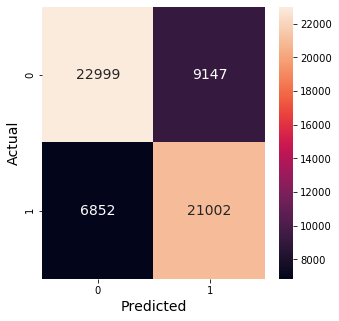

In [29]:
# Calling BernoulliNB model
algorithm_accuracy('BernoulliNB',X_train,X_test, y_train, y_test)

LogR
0.7392666666666666
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     29851
           1       0.73      0.76      0.75     30149

    accuracy                           0.74     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.74      0.74     60000

------------------------------------------


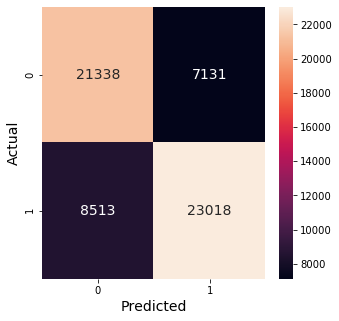

In [30]:
algorithm_accuracy('LogisticRegression',X_train,X_test, y_train, y_test)

From above report for both models Bernoulli and LogRe, we can see that we have almost a balance F1 score, that means we have equal positive and negative in training data from Generic tweets and this is confirms from above plots of positive and negative for generic plots.73% accuracy for BN mode and 74% accuracy for LogR seems good so far for tweets by using a low level of NLP processing. 

# 4. Model Implmentation

After the model was prepared above from the generic tweets where Bernoulli model gives an average accuracy of , and logitic regression gives an average accuracy of . Therefore, to predict US airline sentiment we would use the Bernoulli model. Then testing model to predict sentiment for US airline from the trained model. 

Another model will be prepared from US airlines negative tweets only to predict negative_reasons by using a pipeline assembly technique that proforms TFIDF, SelectKBest and Logistic Regression. 

The Purpose in this section is that, in first model I used Counter Victorizer, and in second model I used TFIDF for purpose of familarized myself with different libraries. 

1. Testing Generic tweet model on the US airline data to predict the sentiments. 
2. Multi class logistic regression to predict the reason for the negative tweets. 
  

## 4.1 Training US Airline Tweets and Predict the Sentiment

In [31]:
# Extracting only text tweet from clean US airlines data, and removing @ from text.
US_airlines = clean_USA_dtf['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))
#print(US_airlines)

# Transforming the US_Airlines tweets in matrix word counts
txt_fitted_airlines_CV = vectorizer.transform(US_airlines)

# Defining training data the X and y values as training datasets
X = txt_fitted_generic_CV # features from generic tweets
y = clean_dtf['sentiment'] # response or sentiments from generic tweets

# Defining testing data fron US airlines tweets and predicted sentiment
X_test = txt_fitted_airlines_CV #tested tweets from US airline tweets 
y_test = clean_USA_dtf['sentiment'] # predicted sentiment for US airlines tweets

#finding the disctinct categories for sentiment in US airlines tweets
category_id_df = clean_USA_dtf['sentiment'].drop_duplicates()
category_to_id = list(category_id_df.values)

BNB
0.7745639407485319
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      9096
           1       0.46      0.60      0.52      2313

    accuracy                           0.77     11409
   macro avg       0.67      0.71      0.69     11409
weighted avg       0.80      0.77      0.79     11409

------------------------------------------


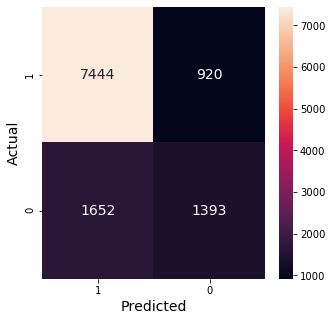

In [32]:
# Calling the algorithm_accuracy function
Result_Training = algorithm_accuracy('BernoulliNB',X, X_test, y, y_test)

LogR
0.7462529581909019
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      9096
           1       0.43      0.73      0.54      2313

    accuracy                           0.75     11409
   macro avg       0.67      0.74      0.68     11409
weighted avg       0.82      0.75      0.77     11409

------------------------------------------


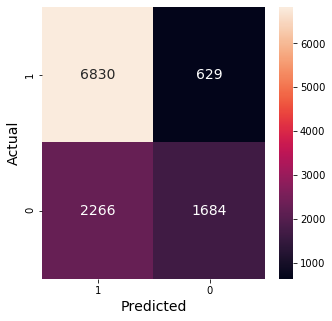

In [33]:
# Calling the algorithm_accuracy function
Result_Training = algorithm_accuracy('LogisticRegression',X, X_test, y, y_test)

Bernoulli model gives us an accuracy of 77.2%, while LogRe gives an accuracy of 74.7%
The total average in both models is balance for F1 at 74.6%.
The F1 score of positive (0.54) and negative (0.83) is not balanced. That is because data provided to us is skwed into negative. 

Improvement will be discussed at Discussion section. 

As Bernoulli Model gives us the highest accuracy score, we will use Bernoulli model to predict US airlines sentiments below.

In [34]:
# Running the Bernoulli NB model to check the predicted US_Airline tweets as it has a higher score 0.77 than LogR 0.74
model = BernoulliNB()
model = model.fit(X,y) # Training the model
y_predict = model.predict(X_test)
Predicted_sentiment = pd.DataFrame({'sentiment':y_predict})
clean_USA_dtf['Predicted_sentiment'] = Predicted_sentiment
clean_USA_dtf['Predicted_sentiment']
clean_USA_dtf.head()

,twitter_hashtags,user,sentiment,test,retweet_count,negative_reason,text,Predicted_sentiment
0,Virgin America,jnardino,1,0,0,,@virginamerica ve commercials experience tacky,1.0
1,Virgin America,jnardino,0,0,0,Bad Flight,@virginamerica aggressive blast obnoxious ente...,1.0
2,Virgin America,jnardino,0,0,0,Can't Tell,@virginamerica big bad thing,0.0
3,Virgin America,jnardino,0,0,0,Can't Tell,@virginamerica seriously pay flight seats didn...,0.0
4,Virgin America,cjmcginnis,1,0,0,,@virginamerica time fly vx ear worm won,0.0


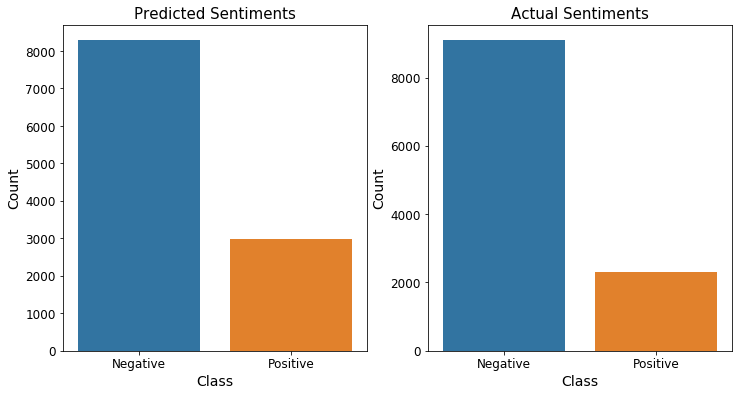

In [35]:
f, axes= plt.subplots(1,2, figsize=(12,6))
p1= sns.countplot(x="Predicted_sentiment", data=clean_USA_dtf, ax= axes[0])
p1.axes.set_title("Predicted Sentiments",fontsize=15)
p1.set_xlabel("Class",fontsize=14)
p1.set_ylabel("Count",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= ['Negative', 'Positive'])
p1= sns.countplot(x="sentiment", data=clean_USA_dtf, ax= axes[1])
p1.axes.set_title("Actual Sentiments",fontsize=15)
p1.set_xlabel("Class",fontsize=14)
p1.set_ylabel("Count",fontsize=14)
p1.tick_params(labelsize=12)
p1.set_xticklabels(labels= ['Negative', 'Positive'])
plt.show()

## 4.2 Multi Class Logistic Regression on Negative Reasons
In this part, we will build a model to predict negative reason from negative US airlines by using pipeline function to assemble all task and give back the result when it is caled.The following steps were performed:

1. **Term frequency - inverse document frequency method**(**TFIDF**), this function will take a set of words from negative tweet to use it as a feature and give it a weight. In addition to that, words with less liklehood to occure will be removed. 


2. **SelectKbest**: I will use selectKbest with Chi-squared stats of non-negative features for classification. In addition, i will give K a value of 400. Putting this together, it will give the highest K statistical score for negative the features which I will used to train.  

3. **logistic regression**: to estimate score of the model. At the LogR we will give it some parameters to train model to give the best possible score. "C" , used for complexity of regression, such that smaller values specify stronger regularization. "max_iter",it represents the maximum number of iteration taken to converge.



**Sources**:
1. TFIDF, http://aimotion.blogspot.com/2011/12/machine-learning-with-python-meeting-tf.html 
2. TFIDF, https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3
3. SelectKbest, https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
4. logistic regreesion, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [36]:
# Exctracting only the negative sentiments from US airline tweets
Neg_dtf_USA = clean_USA_dtf.loc[clean_USA_dtf['sentiment'] == 0]

# Removing the @ from cleaned US airline tweets and splitting data into training 70% and testing 30% 
X_USA = Neg_dtf_USA['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))
y_USA = Neg_dtf_USA['negative_reason']
X_USA_train, X_USA_test, y_USA_train, y_USA_test = train_test_split(X_USA,y_USA,test_size=0.3, random_state=42)

Score  :58.92268230120924
                             precision    recall  f1-score   support

                 Bad Flight       0.48      0.29      0.36       175
                 Can't Tell       0.44      0.34      0.38       352
           Cancelled Flight       0.78      0.69      0.73       244
     Customer Service Issue       0.55      0.78      0.65       851
            Damaged Luggage       1.00      0.04      0.07        26
Flight Attendant Complaints       0.54      0.28      0.37       150
    Flight Booking Problems       0.60      0.33      0.43       157
                Late Flight       0.68      0.71      0.69       502
               Lost Luggage       0.66      0.69      0.68       222
                  longlines       0.00      0.00      0.00        50

                   accuracy                           0.59      2729
                  macro avg       0.57      0.42      0.44      2729
               weighted avg       0.58      0.59      0.57      2729



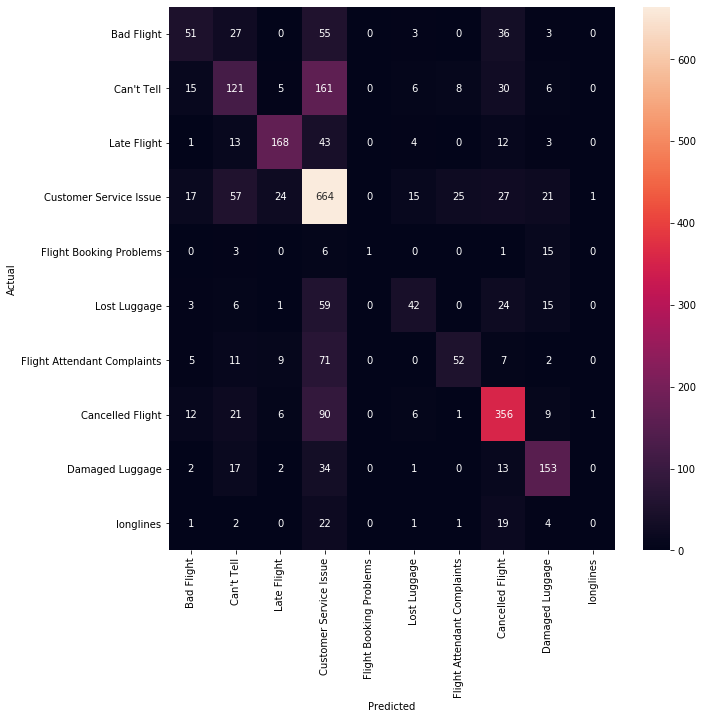

In [37]:
#finding the disctinct categories for negative reason in US airline tweets
category_id_df =Neg_dtf_USA['negative_reason'].drop_duplicates()
category_to_id = list(category_id_df.values)

#Pipeline for tuned Model
pipeline= Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), min_df = 5, max_df = 3000,  stop_words = 'english',  norm = 'l2', binary = True, sublinear_tf = True)),
                      ('chi', SelectKBest(chi2, 400)),
                      ('clf', LogisticRegression(C=2.0, max_iter= 300))]) 
                                                                       
#passing the training features and responses into pipline to victorize it and then making the predictions for both the models
model = pipeline.fit(X_USA_train,y_USA_train) 
prediction= model.predict(X_USA_test)
score = accuracy_score(y_USA_test,prediction)
print ("Score  :"+str(score*100))

#Classification report for Raw model
print(classification_report(y_USA_test,prediction))

#Confusion Matrix for Raw model
conf_mat2 = confusion_matrix(y_USA_test, prediction)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat2, annot=True, fmt='d',xticklabels=category_to_id, yticklabels=category_to_id)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
# Check and test prediction
Training_Pr_Results = pd.DataFrame({'true':y_USA_test,'predicted_negative_reason':prediction,'text':X_USA_test })

Wrong_Prediction = Training_Pr_Results[(Training_Pr_Results['predicted_negative_reason'] != Training_Pr_Results['true'] )]
Wrong_Prediction.head(15)


,true,predicted_negative_reason,text
9835,longlines,Late Flight,americanair sit airport long periolodicly tim...
8532,Customer Service Issue,Bad Flight,usairways flight seattle lbs fuel water lavor...
1519,Can't Tell,Late Flight,united fully boarding flight morning noticing...
9277,Late Flight,Customer Service Issue,americanair extra hours travel time missed va...
1757,Late Flight,Customer Service Issue,united waiting
1546,Customer Service Issue,Lost Luggage,united frustrated conversations united speak ...
152,Flight Booking Problems,Can't Tell,virginamerica change airline dc today united ...
860,Customer Service Issue,Can't Tell,united update told airport call today haven
3334,Can't Tell,Customer Service Issue,united changes stick premiere loyal customers...
2127,Bad Flight,Customer Service Issue,united wasn full plenty time gate check status


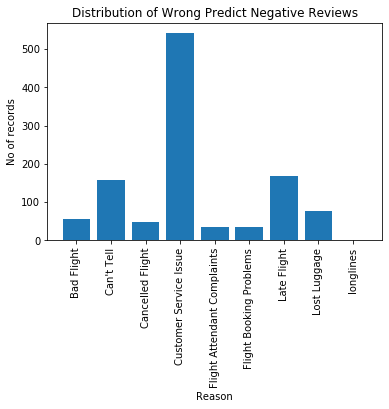

In [39]:
#plotting the predicted negative reason
USA_piv_table6 = pd.pivot_table(Wrong_Prediction, values='text', index=['predicted_negative_reason' ],aggfunc="count")
USA_Netb6= pd.DataFrame(USA_piv_table6.to_records())

plt.bar(USA_Netb6.predicted_negative_reason, USA_Netb6.text)
plt.xlabel('Reason')
plt.ylabel('No of records')
plt.xticks(rotation=90)
plt.title("Distribution of Wrong Predict Negative Reviews")
plt.show()

# 5. Results and Discussion
In this section, I will answer questions provided in the assignment: 
1. **What can public opinion on twitter tell us about the US airlines in 2015?** 
To answer this question in depth, we have to look first into the plot of total number of positive and negative sentiment for USA airline. It is clearly shown that data is skewed into negative sentiments (9178 out of 11541). One more thing we can also look at is positive and negative sentiment for each tweet coresspond to each airline as shown in above plot at section two of  visulaization, the data is not uniformly disterbuted, Why?? It could be that data was collected for only short period (Maybe two months or less, it could be also a fraud user is filling the tweets with negaitve response causing uniform distributions. This can be also shown that for Delta airlines the response I got from my analysi is only one negative and one positive, this is clearly demonstrate why we have not uniform data. So The public judgment based on this visialization analysis (wordCloud for positive and negative airline in addition to bar plot) will be the following: 

*Southwest airlines, Jetblue and virgine America airlines have highest positve sentiment as well as less negative sentiments compared to other airlines. Therefore, they will be viewd as better airlines than others. 

*As Delta airlines does not have enough good records for sentiments, I can not make any judgment at all, I would delte it from the column, but I keept it for purpose of explaination. 

*For more validation skewness of US airlines, when train and predict data,the outcome score of F1 is not balance at all for posotive and negative sentiments.  


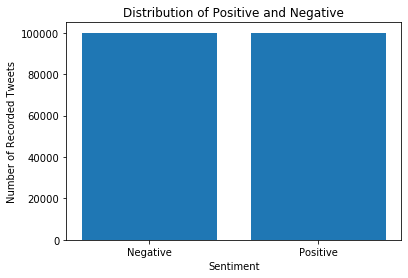

-----------------------------------------------------------------


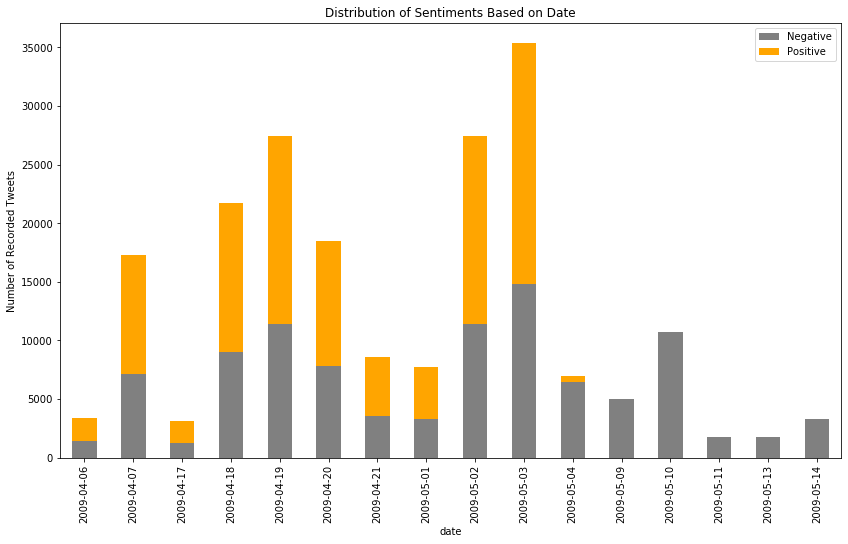

-----------------------------------------------------------------
World Cloud Visualaization for negative tweets of US airlines


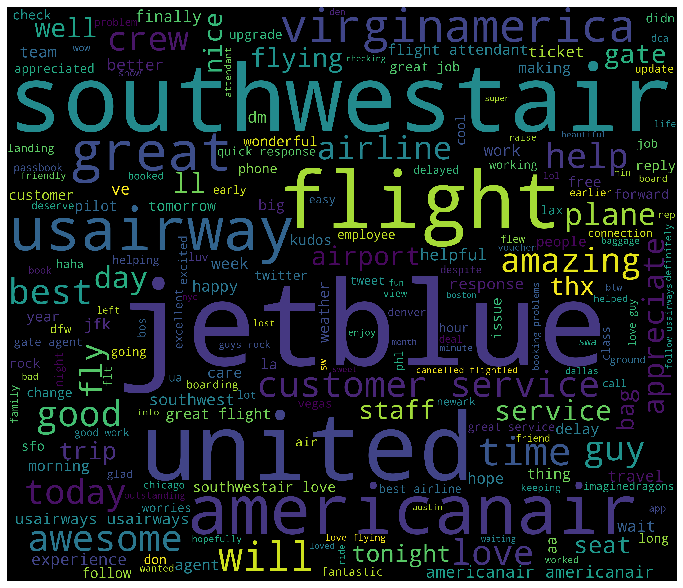

-----------------------------------------------------------------
World Cloud Visualaization for positive tweets of US airlines


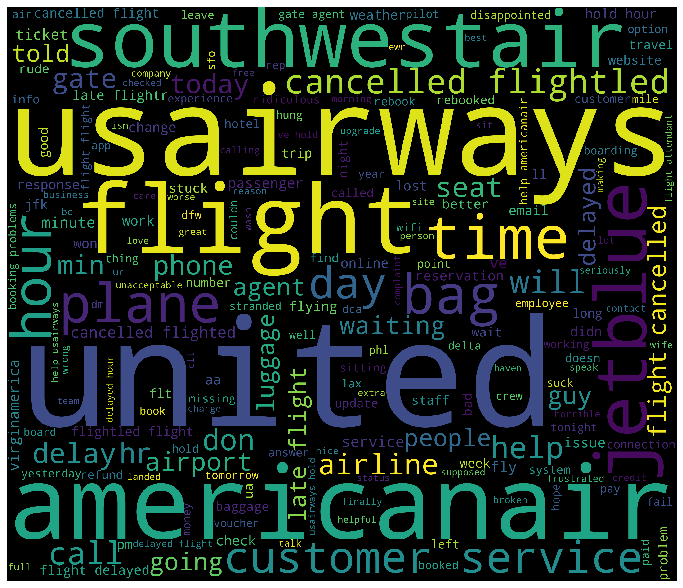

-----------------------------------------------------------------


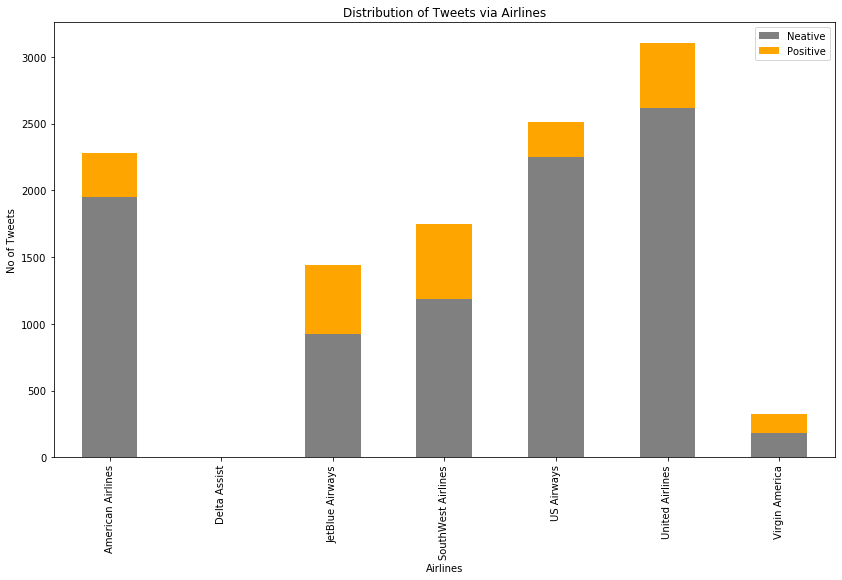

In [40]:
my_bag=['Negative', 'Positive']
plt.bar(dtf2.sentiment, dtf2.test)
plt.xticks(dtf2.sentiment, my_bag)
plt.xlabel('Sentiment')
plt.ylabel('Number of Recorded Tweets')
plt.title('Distribution of Positive and Negative')
plt.show()
clean_dtf.sentiment.value_counts()

print("-----------------------------------------------------------------")

# As stated above in first visualization, using pivot table can help a lot in plotting
table_dtf = dtf1.pivot(index='date', columns='sentiment', values='test')
table_dtf= table_dtf.fillna(0) # To check no NaN value present in table to avoid error in data 
 
table_dtf.loc[:,[0,1]].plot.bar(stacked=True, color=["gray","orange"], figsize=(14,8))
plt.title('Distribution of Sentiments Based on Date')
plt.ylabel('Number of Recorded Tweets')
plt.legend(['Negative', 'Positive'])
plt.show()

print("-----------------------------------------------------------------")

print('World Cloud Visualaization for negative tweets of US airlines')
# World Cloud Visualaization for positive tweets of US airlines. 
USA_positive = clean_USA_dtf[clean_USA_dtf['sentiment']==1]
USA_positive_text = USA_positive['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))

USA_positive_words= pd.Series(USA_positive_text).str.cat(sep=' ')

positive_wordcloud = WordCloud( background_color='black',
                      width=3500,
                      height=3000
                     ).generate(USA_positive_words)

# Plotting word cloud
plt.figure(1,figsize=(12, 12))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

print("-----------------------------------------------------------------")

print('World Cloud Visualaization for positive tweets of US airlines')
# World Cloud Visualaization for positive tweets of US airlines. 
USA_negative = clean_USA_dtf[clean_USA_dtf['sentiment']==0]
USA_negative_text = USA_negative['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))

USA_negative_words= pd.Series(USA_negative_text).str.cat(sep=' ')

negative_wordcloud = WordCloud( background_color='black',
                      width=3500,
                      height=3000
                     ).generate(USA_negative_words)

# Plotting word cloud
plt.figure(1,figsize=(12, 12))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.show()

print("-----------------------------------------------------------------")

#Visualizing Airlines based on tweets
        
tab5 = pd.pivot_table(clean_USA_dtf, values='test', index=['twitter_hashtags','sentiment'],aggfunc="count")
dtf5= pd.DataFrame(tab5.to_records())

piv_tab5 = dtf5.pivot(index='twitter_hashtags', columns='sentiment', values='test')
piv_tab5= piv_tab5.fillna(0)
piv_tab5
piv_tab5.loc[:,[0,1]].plot.bar(stacked=True, color=["gray","orange"], figsize=(14,8))
plt.xlabel("Airlines")
plt.ylabel("No of Tweets")
plt.legend(["Neative", "Positive"])
plt.title("Distribution of Tweets via Airlines")
plt.show()


2. Reasons why your model does not predict efficiently. 
#### Model No1: Predicting the USA airline sentiments from generic tweets data: 
From distribution plot of generic tweets, we have equal positive and negative sentiment (50% probability each) each same for F1 score, both are balanced, so it would be fine to train the model, but why we still have unbalance F1 score when we train USA airlines???? The following could be the reason:
*The data for generic tweets is not related to airlines data, as both could have different work or industrial termonlogies to be used. At cleaning process, we used stop words for generic tweets that probably missing some industrial keywords whcih is not important for our model.Thus, missing these words in stop_words could increase the error in airlinw data as we cleaned them. 

*We can improve the accuracy of the model by adding some industrial words into  stop_words file, sush that during cleaning we will be sure that only important words are remained to be used for training. 

*Another way we can improve the accuracy of the model is setting a dictionary that contains contraction of word and its value is full form of contraction word.Doing this during cleaning and before removing stop_words could increase accuracy as words that will be removed are complete so no missing part of a word will be left.

#### Model No 2: Predicting negative USA airlines reason from negative USA sentiments: 
The alogarithm for predicting and model both function perfectly, the issue behind failing to predict and having a high balanced F1 score is that negative_reasons are not classified or grouped for specific type of tweets, in addition to that the number of negative tweets for each negative_reason are not EQUAL at all, this type of distribution will make the confused and failing to predict negative reason. See below the actual predicted results for model 2: 


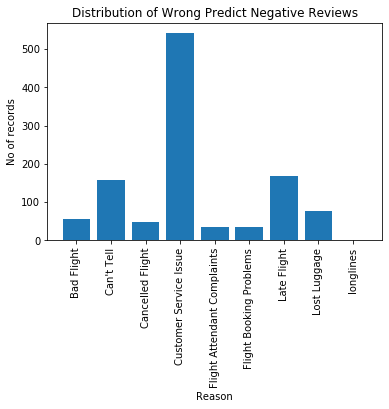

-----------------------------------------------------------------


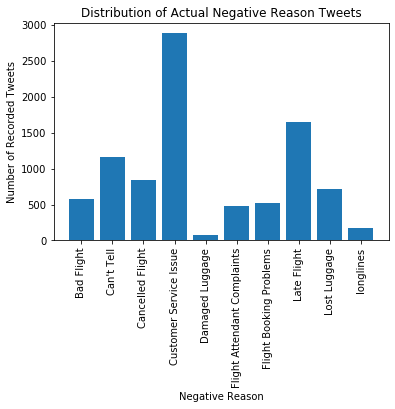

In [41]:
# Check and test prediction
Training_Pr_Results = pd.DataFrame({'true':y_USA_test,'predicted_negative_reason':prediction,'text':X_USA_test })

Wrong_Prediction = Training_Pr_Results[(Training_Pr_Results['predicted_negative_reason'] != Training_Pr_Results['true'] )]
Wrong_Prediction.head(15)

USA_piv_table6 = pd.pivot_table(Wrong_Prediction, values='text', index=['predicted_negative_reason' ],aggfunc="count")
USA_Netb6= pd.DataFrame(USA_piv_table6.to_records())
USA_Netb6['Fraction'] = np.round(100* USA_Netb6['text'] / USA_Netb6['text'].sum(),2) 

plt.bar(USA_Netb6.predicted_negative_reason, USA_Netb6.text)
plt.xlabel('Reason')
plt.ylabel('No of records')
plt.xticks(rotation=90)
plt.title("Distribution of Wrong Predict Negative Reviews")
plt.show()
print("-----------------------------------------------------------------")
plt.bar(dtf4.negative_reason, dtf4.test)
plt.xlabel('Negative Reason')
plt.ylabel('Number of Recorded Tweets')
plt.xticks(rotation=90) # To rotate words vertically
plt.title("Distribution of Actual Negative Reason Tweets")
plt.show()

#### To improve Model No 2, 
we have to group each class of negative_reason with respect to negative tweets such that we can improve model prediction as shown below here. We were able to improve model from 61.2% to 74.1% in by using LogReg 


LogR
0.7382413087934561
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       690
           1       0.77      0.69      0.72      1165
           2       0.74      0.78      0.76      1568

    accuracy                           0.74      3423
   macro avg       0.73      0.73      0.73      3423
weighted avg       0.74      0.74      0.74      3423

------------------------------------------


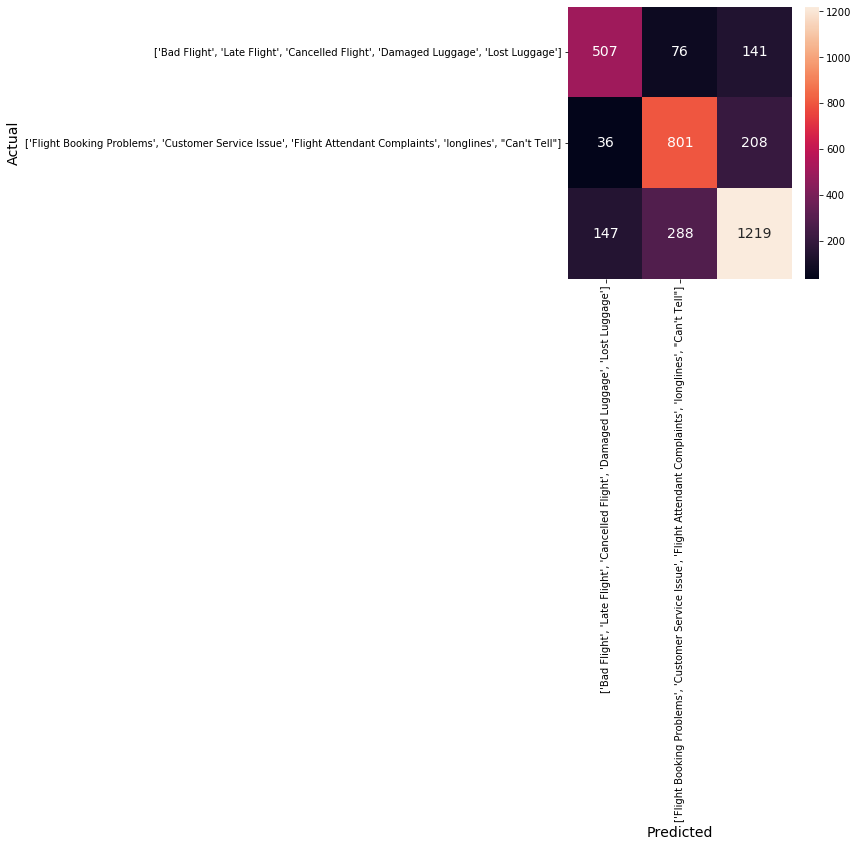

In [42]:
#finding the disctinct categories for negative reason in US airline tweets
#category_id_df =Neg_dtf_USA['negative_reason'].drop_duplicates()


# Extracting only text tweet from clean US airlines data, and removing @ from text.
US_airlines_stext = clean_USA_dtf['text'].apply(lambda text:re.sub("[^a-zA-Z]+", " ", text))

# Using Count Vectorization to tokenize the words and give the count of the words as done previously in logistic regression.-
vectorizer = CountVectorizer(stop_words="english", analyzer='word', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)
vectorizer.fit(US_airlines_stext)
fitted_airlines = vectorizer.fit_transform(US_airlines_stext)

# Grouping neagtive_reason classes 
list1 = ['Bad Flight' , 'Late Flight' , 'Cancelled Flight','Damaged Luggage','Lost Luggage']
list2 = ['Flight Booking Problems' , 'Customer Service Issue','Flight Attendant Complaints','longlines','Can\'t Tell']

category_to_id = (list1,list2)
Negative_Rea_Scoring =[]
reasons = clean_USA_dtf['negative_reason']
for x in reasons:
    if x in list1:
        Negative_Rea_Scoring.append(1)
    elif x in list2:
        Negative_Rea_Scoring.append(2)
    else:
        Negative_Rea_Scoring.append(0)

clean_USA_dtf['Negative_Grouped_Scoring'] = Negative_Rea_Scoring

#Defining the X and y values
X = fitted_airlines
y = clean_USA_dtf['Negative_Grouped_Scoring']

# Splitting the dataset into training/testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#calling the function
result_3 = algorithm_accuracy('LogisticRegression',X_train,X_test, y_train, y_test)

BNB
0.7145778556821502
              precision    recall  f1-score   support

           0       0.79      0.47      0.59       690
           1       0.76      0.70      0.73      1165
           2       0.67      0.83      0.75      1568

    accuracy                           0.71      3423
   macro avg       0.74      0.67      0.69      3423
weighted avg       0.73      0.71      0.71      3423

------------------------------------------


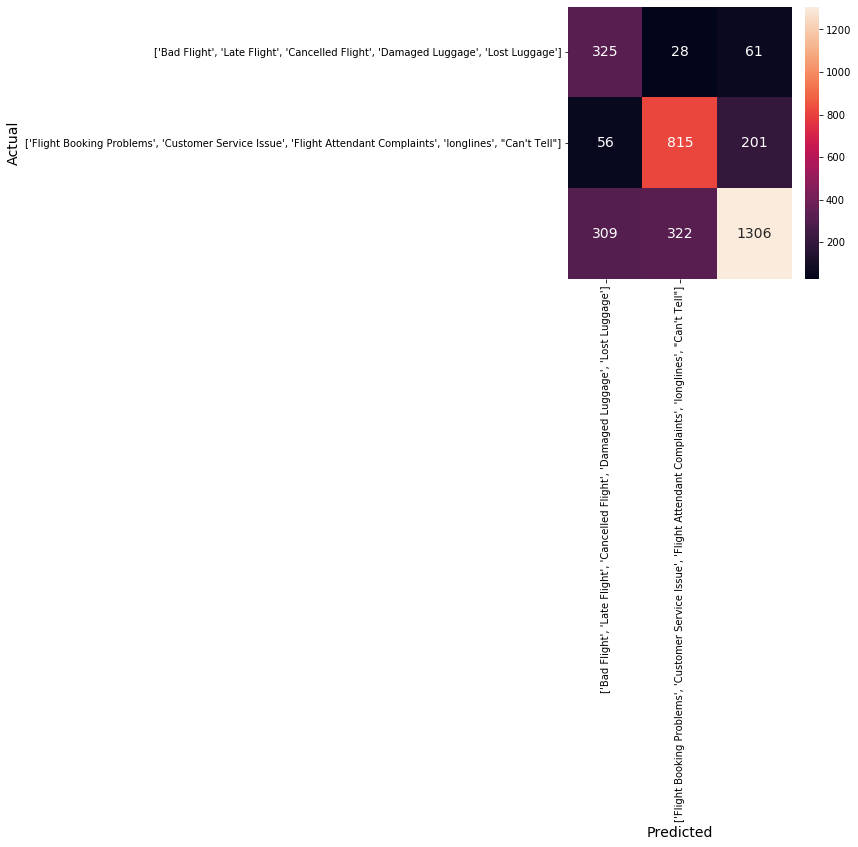

In [43]:
result_3 = algorithm_accuracy('BernoulliNB',X_train,X_test, y_train, y_test)

#### General possible to improve accuracy score for models.
1. Traing the model by varying features (tweets weight). 
2. We can train model by using Bi gram models.
3. Train the model with most frequent words from the generic tweets or airline tweets.